<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/evento_de_notch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

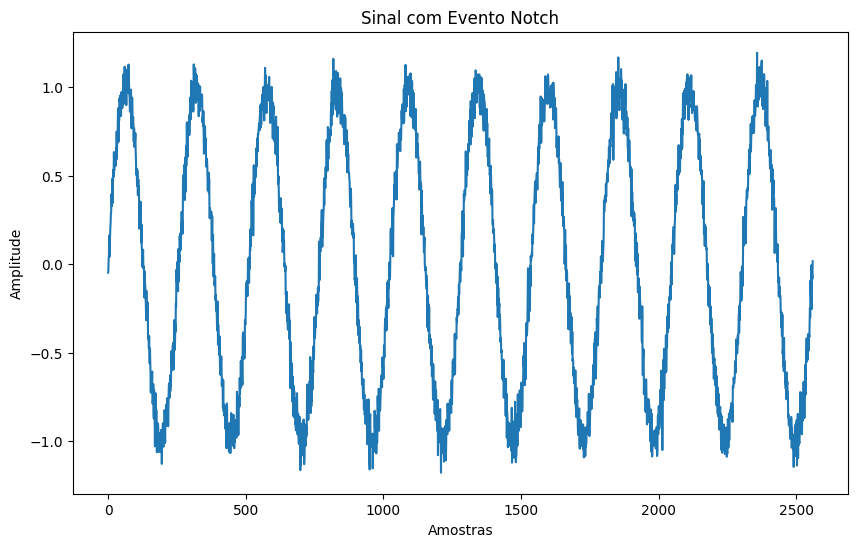

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evento_notch(SNRdb):
    Vm1 = 1  # Valor máximo do 1º harmônico
    fase = 0  # Fase da componente fundamental
    FreqFund = 60  # Frequência fundamental (60 Hz)

    Npc = 256  # Número de pontos por ciclo
    Nc = 10  # Número de ciclos
    Npt = Nc * Npc  # Número total de pontos
    Fs = Npc * 60  # Frequência de amostragem
    T = 1 / Fs  # Período de amostragem

    w0 = 2 * np.pi * FreqFund  # Frequência em radianos

    t = np.arange(0, T * Npt, T)
    x1 = Vm1 * np.sin(w0 * t + fase)  # Sinal senoidal

    # Geração do evento de distúrbio ("notch")
    Npc_dist = np.random.randint(7 * Npc, 8 * Npc)  # Índice da amostra onde ocorre o distúrbio
    n = Npc_dist
    a = np.random.uniform(1000, 2000)  # Amortecimento
    freq = np.random.uniform(1000, 3000)  # Frequência de oscilação
    k = np.random.uniform(0.1, 0.4)  # Constante do distúrbio
    t_dist = np.random.randint(0.01 * Npc, 0.05 * Npc)  # Duração do distúrbio
    n2 = 1
    periodo = 32

    dist = np.zeros(Nc * Npc)  # Inicializa o vetor de distúrbio

    for n1 in range(1, Nc * Npc + 1):
        if (n1 > Npc_dist) and (n1 < Npc_dist + t_dist):
            dist[n1 - 1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if (n1 == (Npc_dist + t_dist)) and (n1 < Nc * Npc - periodo - t_dist):
                Npc_dist += periodo
                k = np.random.uniform(0.1, 0.4)
                n2 = 1
        else:
            dist[n1 - 1] = 0

    # Adição de ruído ao sinal
    Ps = (Vm1**2) / 2
    Pr = Ps / (10**(SNRdb / 10))  # Potência do ruído
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, Nc * Npc)  # Geração do ruído
    R = R - np.mean(R)

    # Sinal final com distúrbio e ruído
    xIn = x1 + dist + R
    return xIn, n, Nc, FreqFund

# Teste do evento_notch com SNR de 20 dB
xIn, n, Nc, FreqFund = evento_notch(20)

# Plotagem do sinal gerado
plt.figure(figsize=(10, 6))
plt.plot(xIn)
plt.title('Sinal com Evento Notch')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()


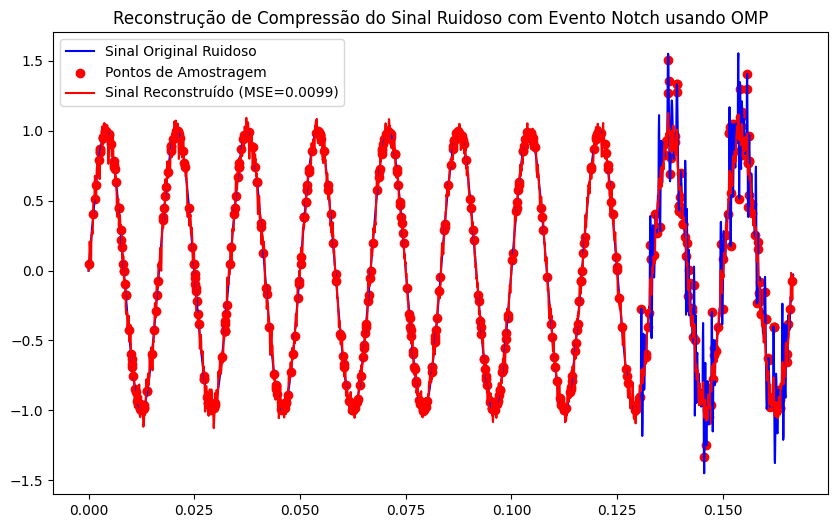

In [ ]:

from sklearn.linear_model import OrthogonalMatchingPursuit

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

def evento_notch(SNRdb, n, T, Npc, Nc, FreqFund):
    AmpMin = 0.45
    Vm1 = 1
    fase = 0
    w0 = 2 * np.pi * FreqFund

    t = T * np.arange(0, n)
    x1 = Vm1 * np.sin(w0 * t + fase)

    a = np.random.uniform(1000, 2000)
    freq = np.random.uniform(1000, 3000)
    Npc_dist = np.random.randint(7 * Npc, 8 * Npc)
    n_dist = Npc_dist
    k = 0.7

    n2 = 0
    periodo = 32

    dist = np.zeros(n)
    for n1 in range(0, n):
        if n1 > Npc_dist:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (Npc_dist + periodo) and (n1 < Nc * Npc - periodo):
                Npc_dist += periodo
                a = np.random.uniform(1000, 2000)
                freq = np.random.uniform(1000, 3000)
                n2 = 0
        if n1 <= Npc_dist:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = x1 + dist + R

    return xIn, n_dist, Nc, FreqFund

# Configurações
SNRdb = 60
Npc = 256
T = 1 / (Npc * 60)
Nc = 10
n = Nc * Npc
FreqFund = 60

# Geração do sinal com a introdução de ruído
xIn, _, _, _ = evento_notch(SNRdb, n, T, Npc, Nc, FreqFund)

# Amostragem aleatória do sinal ruidoso
p = 520
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa

# Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
Phi = np.fft.fft(np.eye(n, n)) * 1
CPhi = np.imag(Phi[amostras_aleatorias, :])

# OMP para minimização de l1
s_reconstruido = omp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo OMP
x_rec = np.imag(np.fft.fft(s_reconstruido))
# Calcular o MSE
mse_omp = calculate_mse(xIn, x_rec[:len(xIn)])

# Visualizar o sinal original ruidoso com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = T * np.arange(0, len(xIn))
plt.plot(t, xIn, 'b', label='Sinal Original Ruidoso')
plt.scatter(np.arange(0, T * n, T)[amostras_aleatorias], xIn[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (MSE={mse_omp:.4f})')
plt.title('Reconstrução de Compressão do Sinal Ruidoso com Evento Notch usando OMP')
plt.legend()
plt.show()


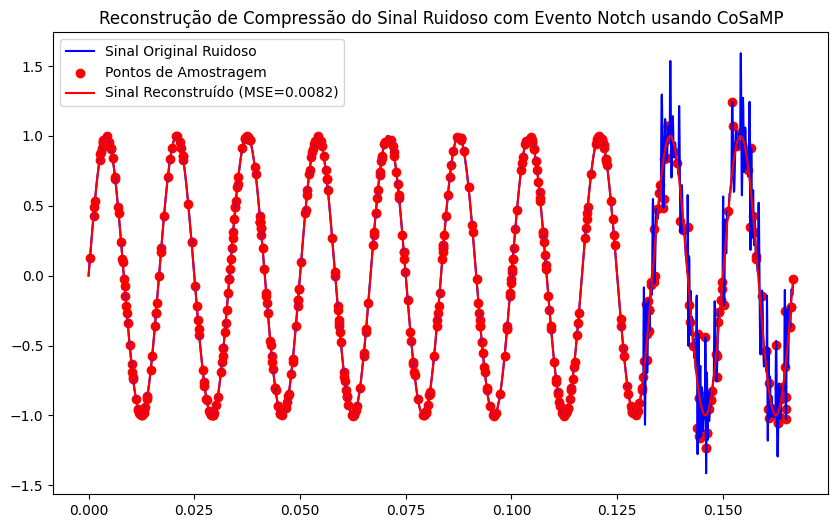

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Função para realizar a reconstrução esparsa usando o algoritmo CoSaMP
def cosamp(Phi, u, s, max_iter=100, tol=1e-10):
    # Inicialização
    m, n = Phi.shape
    r = u.copy()  # Resíduo
    iter = 0
    T = np.zeros(n)  # Conjunto de suporte estimado
    while iter < max_iter and np.linalg.norm(r) > tol:
        # Passo 1: Atualizar a estimativa de suporte
        y = np.dot(Phi.T, r)
        omega = np.argsort(np.abs(y))[::-1][:2*s]  # Escolher os 2s maiores componentes
        T = np.union1d(T, omega)
        T = np.intersect1d(T.astype(int), np.flatnonzero(np.abs(y[T.astype(int)]) > np.linalg.norm(r) / 2))

        #T = np.intersect1d(T, np.flatnonzero(np.abs(y[T]) > np.linalg.norm(r) / 2))

        # Passo 2: Resolver mínimos quadrados
        A = Phi[:, T]
        x = np.zeros(n)
        x[T] = np.linalg.lstsq(A, u, rcond=None)[0]

        # Passo 3: Poda
        omega = np.argsort(np.abs(x))[::-1][:s]  # Escolher os s maiores componentes
        T = np.flatnonzero(np.abs(x) > np.sort(np.abs(x))[::-1][s])

        # Atualizar resíduo
        r = u - np.dot(Phi[:, T], x[T])
        iter += 1

    return x

# Função para calcular o erro quadrático médio (MSE)
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

# Função para gerar o evento notch no sinal
def evento_notch(SNRdb, n, T, Npc, Nc, FreqFund):
    AmpMin = 0.45
    Vm1 = 1
    fase = 0
    w0 = 2 * np.pi * FreqFund

    t = T * np.arange(0, n)
    x1 = Vm1 * np.sin(w0 * t + fase)

    a = np.random.uniform(1000, 2000)
    freq = np.random.uniform(1000, 3000)
    Npc_dist = np.random.randint(7 * Npc, 8 * Npc)
    n_dist = Npc_dist
    k = 0.7

    n2 = 0
    periodo = 32

    dist = np.zeros(n)
    for n1 in range(0, n):
        if n1 > Npc_dist:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (Npc_dist + periodo) and (n1 < Nc * Npc - periodo):
                Npc_dist += periodo
                a = np.random.uniform(1000, 2000)
                freq = np.random.uniform(1000, 3000)
                n2 = 0
        if n1 <= Npc_dist:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = x1 + dist + R

    return xIn, n_dist, Nc, FreqFund

# Configurações
SNRdb = 60
Npc = 256
T = 1 / (Npc * 60)
Nc = 10
n = Nc * Npc
FreqFund = 60

# Geração do sinal com a introdução de ruído
xIn, _, _, _ = evento_notch(SNRdb, n, T, Npc, Nc, FreqFund)

# Amostragem aleatória do sinal ruidoso
p = 520
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa

# Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
Phi = np.fft.fft(np.eye(n, n)) * 1
CPhi = np.imag(Phi[amostras_aleatorias, :])

# CoSaMP para minimização de l1
s_reconstruido = cosamp(CPhi, y, 10)  # Obtendo o vetor esparsa usando CoSaMP
x_rec = np.imag(np.fft.fft(s_reconstruido))

# Calcular o MSE
mse_cosamp = calculate_mse(xIn, x_rec[:len(xIn)])

# Visualizar o sinal original ruidoso com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = T * np.arange(0, len(xIn))
plt.plot(t, xIn, 'b', label='Sinal Original Ruidoso')
plt.scatter(np.arange(0, T * n, T)[amostras_aleatorias], xIn[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (MSE={mse_cosamp:.4f})')
plt.title('Reconstrução de Compressão do Sinal Ruidoso com Evento Notch usando CoSaMP')
plt.legend()
plt.show()
